In [1]:
#@title Importing Libraries
import numpy as np
from scipy.stats import norm
import math
from math import log, sqrt, pi, exp
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import yfinance as yf

In [2]:
ticker = 'AAPL'
option = yf.Ticker(ticker)
option.options

('2024-07-12',
 '2024-07-19',
 '2024-07-26',
 '2024-08-02',
 '2024-08-09',
 '2024-08-16',
 '2024-08-23',
 '2024-09-20',
 '2024-10-18',
 '2024-11-15',
 '2024-12-20',
 '2025-01-17',
 '2025-03-21',
 '2025-06-20',
 '2025-09-19',
 '2025-12-19',
 '2026-01-16',
 '2026-06-18',
 '2026-12-18')

In [4]:
#@title Getting the Call Dataset
# Picking a date from the above
date = '2024-09-20'

def fetch_options_data(ticker_symbol, date):
    ticker = yf.Ticker(ticker_symbol)
    options_data = ticker.option_chain(date)
    return options_data.calls, options_data.puts



calls, puts = fetch_options_data(ticker, date)
calls = pd.DataFrame(calls)
calls.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL240920C00005000,2024-07-09 17:21:19+00:00,5.0,223.40,226.65,227.10,0.0,0.0,10,13,3.539064,True,REGULAR,USD
1,AAPL240920C00010000,2024-05-03 17:28:52+00:00,10.0,175.16,180.50,184.15,0.0,0.0,11,0,0.000010,True,REGULAR,USD
2,AAPL240920C00015000,2024-02-26 16:20:42+00:00,15.0,166.23,157.55,158.95,0.0,0.0,1,2,0.000010,True,REGULAR,USD
3,AAPL240920C00020000,2024-03-22 14:59:56+00:00,20.0,152.13,144.00,146.25,0.0,0.0,1,5,0.000010,True,REGULAR,USD
4,AAPL240920C00025000,2024-04-01 15:16:35+00:00,25.0,144.84,145.05,147.25,0.0,0.0,1,2,0.000010,True,REGULAR,USD


In [19]:
#@title Binomial Model
## define Cox_Ross_Rubinstein binomial model
def Cox_Ross_Rubinstein_Tree (S,K,T,r,sigma, Option_type, N = 100):

    # Underlying price (per share): S;
    # Strike price of the option (per share): K;
    # Time to maturity (years): T;
    # Continuously compounding risk-free interest rate: r;
    # Volatility: sigma;
    # Number of binomial steps: N;

        # The factor by which the price rises (assuming it rises) = u ;
        # The factor by which the price falls (assuming it falls) = d ;
        # The probability of a price rise = pu ;
        # The probability of a price fall = pd ;
        # discount rate = disc ;

    u=math.exp(sigma*math.sqrt(T/N));
    d=math.exp(-sigma*math.sqrt(T/N));
    pu=((math.exp(r*T/N))-d)/(u-d);
    pd=1-pu;
    disc=math.exp(-r*T/N);

    St = [0] * (N+1)
    C = [0] * (N+1)

    St[0]=S*d**N;

    for j in range(1, N+1):
        St[j] = St[j-1] * u/d;

    for j in range(1, N+1):
        if Option_type == 'P':
            C[j] = max(K-St[j],0);
        elif Option_type == 'C':
            C[j] = max(St[j]-K,0);

    for i in range(N, 0, -1):
        for j in range(0, i):
            C[j] = disc*(pu*C[j+1]+pd*C[j]);

    return C[0]

In [18]:
#@title Black-Scholes Model
# Underlying price (per share): S;
# Strike price of the option (per share): K;
# Time to maturity (years): T;
# Continuously compounding risk-free interest rate: r;
# Volatility: sigma;

## define two functions, d1 and d2 in Black-Scholes model
def d1(S,K,T,r,sigma):
    return(log(S/K)+(r+sigma**2/2.)*T)/sigma*sqrt(T)
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)

## define the call options price function
def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))

## define the put options price function
def bs_put(S,K,T,r,sigma):
    return K*exp(-r*T)-S+bs_call(S,K,T,r,sigma)

In [28]:
#@title Defining inputs for the models
def get_current_stock_price(ticker_symbol):
    stock = yf.Ticker(ticker_symbol)
    current_price = stock.history(period='1d')['Close'].iloc[-1]
    return current_price



def get_10yr_treasury_rate():
    # 10 year treasury ticker symbol
    treasury_ticker = "^TNX"

    now = datetime.now()
    ten_years_ago = now.replace(year=now.year - 10)

    treasury_data = yf.download(treasury_ticker, start=ten_years_ago, end=now)
    last_yield = treasury_data['Close'].iloc[-1]
    return last_yield



def get_date(date_str):
    # Assuming the date string is in the format 'YYYY-MM-DD'
    date_object = datetime.strptime(date_str, '%Y-%m-%d')

    current_date = datetime.now()
    years_difference = (date_object - current_date).days / 365.25
    return years_difference



def calculate_volatility(ticker):

    today = datetime.now()
    one_year_ago = today.replace(year=today.year-1)
    data = yf.download(ticker, start=one_year_ago, end=today)

    # Calculate daily returns
    data['Daily_Return'] = data['Adj Close'].pct_change()

    # std of daily returns
    daily_volatility = data['Daily_Return'].std()
    annualized_volatility = daily_volatility * np.sqrt(252)

    return annualized_volatility



S = get_current_stock_price(ticker)
r = get_10yr_treasury_rate()
t = get_date(date)
vol = calculate_volatility(ticker)

# Converting r to percentage
r = r / 100

print(f"Riskfree rate: {r}")
print(f"Years difference: {t}")
print(f"The current stock price of {ticker} is: {S}")
print(f"Stock price of {ticker}: {S}")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Riskfree rate: 0.04195000171661377
Years difference: 2.431211498973306
The current stock price of AAPL is: 230.84010314941406
Stock price of AAPL: 230.84010314941406


In [13]:
main_df = calls.copy()
columns_to_drop = ['lastTradeDate',  'volume', 'openInterest', 'contractSize', 'currency']
main_df.drop(columns=columns_to_drop, inplace=True)
main_df['bsmValuation'] = main_df.apply(lambda row: bs_call(S, row['strike'], t, r, vol), axis=1)
main_df['binValuation'] = main_df.apply(lambda row: Cox_Ross_Rubinstein_Tree(S, row['strike'], t, r, vol, 'C'), axis=1)
main_df.head(10)

,contractSymbol,strike,lastPrice,bid,ask,change,percentChange,impliedVolatility,inTheMoney,bsmValuation,binValuation
0,AAPL240920C00005000,5.0,223.40,226.65,227.10,0.0,0.0,3.539064,True,226.859503,226.859503
1,AAPL240920C00010000,10.0,175.16,180.50,184.15,0.0,0.0,0.000010,True,221.898999,221.898999
2,AAPL240920C00015000,15.0,166.23,157.55,158.95,0.0,0.0,0.000010,True,216.938485,216.938495
3,AAPL240920C00020000,20.0,152.13,144.00,146.25,0.0,0.0,0.000010,True,211.977824,211.977990
4,AAPL240920C00025000,25.0,144.84,145.05,147.25,0.0,0.0,0.000010,True,207.016209,207.017486
5,AAPL240920C00030000,30.0,154.79,160.70,164.35,0.0,0.0,0.000010,True,202.051103,202.056982
6,AAPL240920C00035000,35.0,147.99,162.05,162.65,0.0,0.0,0.000010,True,197.077113,197.096478
7,AAPL240920C00040000,40.0,142.89,157.15,157.70,0.0,0.0,0.000010,True,192.085444,192.135973
8,AAPL240920C00045000,45.0,171.47,186.70,187.35,0.0,0.0,1.608400,True,187.064251,187.175469
9,AAPL240920C00050000,50.0,179.19,181.75,182.40,0.0,0.0,1.543948,True,181.999767,182.214965


Mean Absolute Error (Black-Scholes): 14.14
Mean Absolute Error (Binomial): 12.06


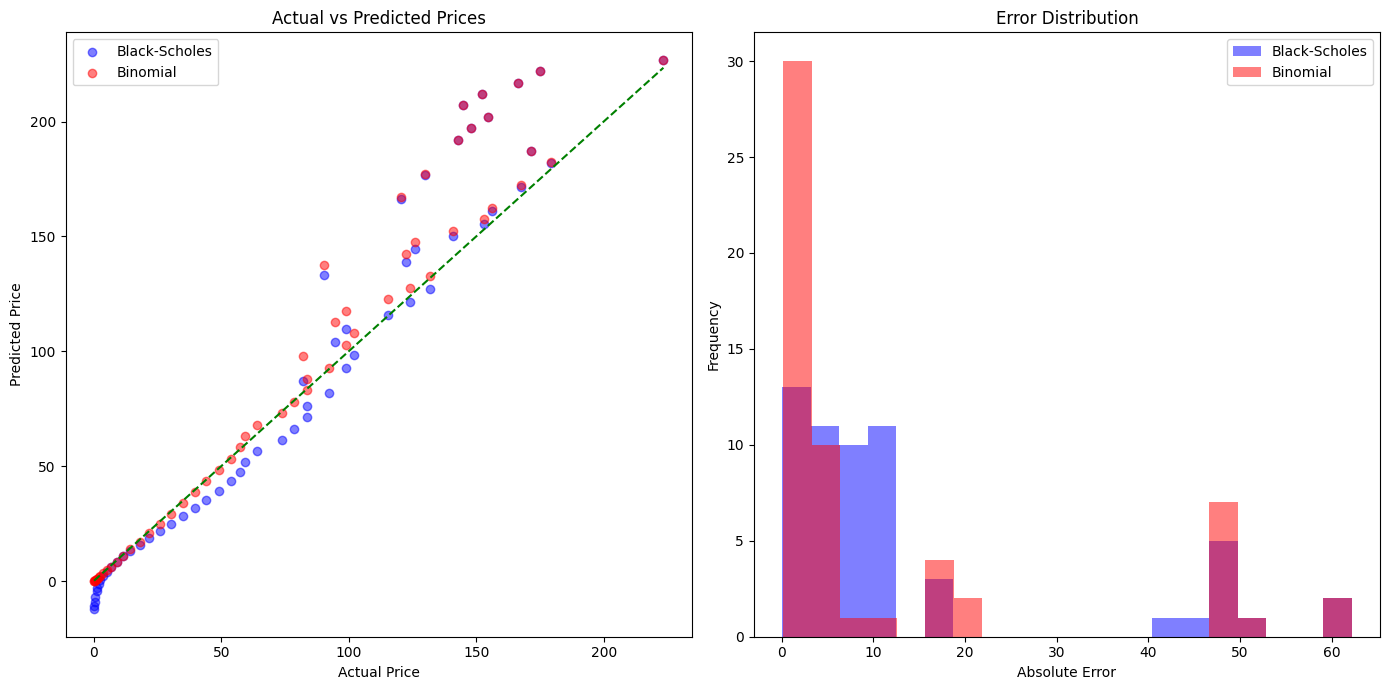

In [14]:
#@title Visualising Result
# Calculate absolute errors
main_df['absErrorBS'] = np.abs(main_df['lastPrice'] - main_df['bsmValuation'])
main_df['absErrorBin'] = np.abs(main_df['lastPrice'] - main_df['binValuation'])

# Calculate mean absolute errors
mean_abs_error_bs = main_df['absErrorBS'].mean()
mean_abs_error_bin = main_df['absErrorBin'].mean()

print(f"Mean Absolute Error (Black-Scholes): {mean_abs_error_bs:.2f}")
print(f"Mean Absolute Error (Binomial): {mean_abs_error_bin:.2f}")

# Plot actual vs predicted prices
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.scatter(main_df['lastPrice'], main_df['bsmValuation'], color='blue', label='Black-Scholes', alpha=0.5)
plt.scatter(main_df['lastPrice'], main_df['binValuation'], color='red', label='Binomial', alpha=0.5)
plt.plot([main_df['lastPrice'].min(), main_df['lastPrice'].max()],
         [main_df['lastPrice'].min(), main_df['lastPrice'].max()],
         color='green', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.legend()

# Plot error distributions
plt.subplot(1, 2, 2)
plt.hist(main_df['absErrorBS'], bins=20, alpha=0.5, label='Black-Scholes', color='blue')
plt.hist(main_df['absErrorBin'], bins=20, alpha=0.5, label='Binomial', color='red')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.legend()

plt.tight_layout()
plt.show()

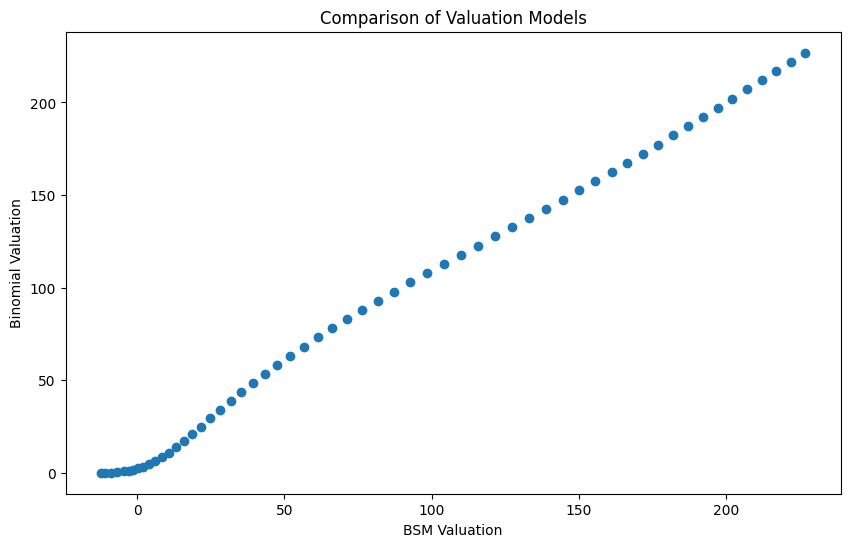

In [12]:
# @title Comparison of Valuation Models

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(main_df['bsmValuation'], main_df['binValuation'])
plt.xlabel('BSM Valuation')
plt.ylabel('Binomial Valuation')
_ = plt.title('Comparison of Valuation Models')


In [27]:
date = '2026-12-18'

def fetch_options_data(ticker_symbol, date):
    ticker = yf.Ticker(ticker_symbol)
    options_data = ticker.option_chain(date)
    return options_data.calls, options_data.puts



calls, puts = fetch_options_data(ticker, date)
puts = pd.DataFrame(puts)
puts.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL261218P00050000,2024-07-09 13:54:32+00:00,50.0,0.18,0.15,0.27,0.0,0.0,8,178,0.430181,False,REGULAR,USD
1,AAPL261218P00060000,2024-07-11 14:44:58+00:00,60.0,0.45,0.21,0.46,0.0,0.0,2,32,0.409918,False,REGULAR,USD
2,AAPL261218P00070000,2024-06-26 13:30:03+00:00,70.0,0.45,0.36,0.58,0.0,0.0,1,46,0.377936,False,REGULAR,USD
3,AAPL261218P00080000,2024-07-09 13:45:35+00:00,80.0,0.60,0.51,0.58,0.0,0.0,4,233,0.338141,False,REGULAR,USD
4,AAPL261218P00085000,2024-06-25 14:44:55+00:00,85.0,0.67,0.60,0.87,0.0,0.0,4,41,0.342292,False,REGULAR,USD


In [29]:
main_df = puts.copy()
columns_to_drop = ['lastTradeDate', 'volume', 'openInterest', 'contractSize', 'currency']
main_df.drop(columns=columns_to_drop, inplace=True)
main_df['bsmValuation'] = main_df.apply(lambda row: bs_put(S, row['strike'], t, r, vol), axis=1)
main_df['binValuation'] = main_df.apply(lambda row: Cox_Ross_Rubinstein_Tree(S, row['strike'], t, r, vol, 'P'), axis=1)
main_df.head(10)

,contractSymbol,strike,lastPrice,bid,ask,change,percentChange,impliedVolatility,inTheMoney,bsmValuation,binValuation
0,AAPL261218P00050000,50.0,0.18,0.15,0.27,0.00,0.000000,0.430181,False,0.000000e+00,0.000006
1,AAPL261218P00060000,60.0,0.45,0.21,0.46,0.00,0.000000,0.409918,False,0.000000e+00,0.000107
2,AAPL261218P00070000,70.0,0.45,0.36,0.58,0.00,0.000000,0.377936,False,0.000000e+00,0.000840
3,AAPL261218P00080000,80.0,0.60,0.51,0.58,0.00,0.000000,0.338141,False,0.000000e+00,0.004474
4,AAPL261218P00085000,85.0,0.67,0.60,0.87,0.00,0.000000,0.342292,False,2.557954e-13,0.009172
5,AAPL261218P00090000,90.0,0.75,0.65,0.85,0.00,0.000000,0.322883,False,5.599077e-12,0.017428
6,AAPL261218P00095000,95.0,0.80,0.67,1.00,0.00,0.000000,0.314948,False,9.191581e-11,0.030633
7,AAPL261218P00100000,100.0,1.06,0.84,1.28,-0.06,-5.357148,0.312629,False,1.146304e-09,0.049902
8,AAPL261218P00105000,105.0,1.27,1.03,1.49,0.00,0.000000,0.305427,False,1.122640e-08,0.083779
9,AAPL261218P00110000,110.0,1.52,1.40,1.55,0.00,0.000000,0.291755,False,8.878604e-08,0.131019
